In [1]:
import pandas as pd
import numpy as np
import math
import os
import statistics as stat

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# 5ª Filamentação

In [2]:
############################### Importando os dados ##############################################

caminho_pasta = "5ª Filamentacao"

arquivos = os.listdir(caminho_pasta)

diametros_quinta = [0.047, 0.044, 0.029, 0.044, 0.034, 0.032, 0.048]

diametros_quinta1 = [i * 1000 for i in diametros_quinta] # converter de mm para um

dados = list()

caminho_pasta1= "5ª Filamentacao/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))

In [3]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros_quinta1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau



------------------------------------ Todos os CPs -------------------------------------------

         CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
5F_CP10.txt                 47.0           155.722557               2.754975              10.173744
 5F_CP2.txt                 44.0           225.555438               2.976250              12.756670
 5F_CP3.txt                 29.0           271.864651               5.408900              15.307882
 5F_CP4.txt                 44.0           280.881510               4.909600              14.006108
 5F_CP5.txt                 34.0           238.765457               4.914850              17.723899
 5F_CP6.txt                 32.0           283.622812               1.292850              28.869082
 5F_CP8.txt                 48.0           176.123734               2.724700              11.248250

----------------------------- Após eliminação de outliers -----------------------------------

        

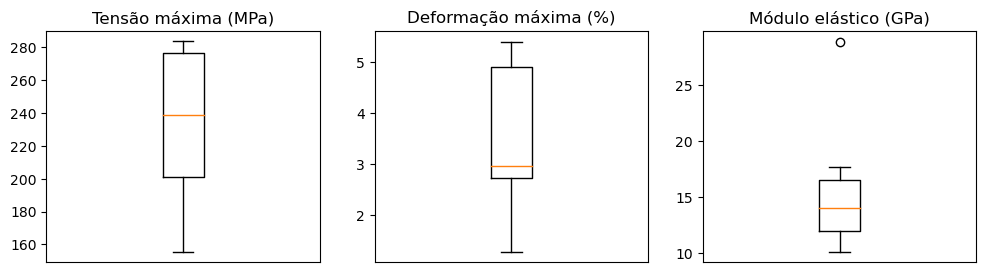

In [4]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros_quinta1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [5]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))


Tensão máxima média (MPa): 224.82 ± 46.00
 
Deformação máxima média (%): 3.95 ± 1.14
 
Módulo elástico (GPa): 13.54 ± 2.52



# 6ª Filamentação

In [6]:
############################### Importando os dados ##############################################

caminho_pasta = "6ª Filamentacao"

arquivos = os.listdir(caminho_pasta)

diametros_sexta = [0.043, 0.046, 0.042, 0.047, 0.048, 0.048, 0.044, 0.074]

diametros_sexta1 = [i * 1000 for i in diametros_sexta] # converter de mm para um

dados = list()

caminho_pasta1= "6ª Filamentacao/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))

In [7]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros_sexta1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau


------------------------------------ Todos os CPs -------------------------------------------

      CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
 cp1.txt                 43.0           194.953701               4.182800              15.039891
cp10.txt                 46.0           204.424385               4.091285              17.227018
cp11.txt                 42.0           151.797726               9.498350              10.777465
cp12.txt                 47.0           133.343398               7.633350              11.324795
cp13.txt                 48.0           134.993786               4.632200               6.800874
 cp3.txt                 48.0          2243.066769               0.998715              29.487287
 cp7.txt                 44.0           137.246805              10.016550               9.690875
 cp9.txt                 74.0            66.579082               4.165055               6.310402

----------------------------- 

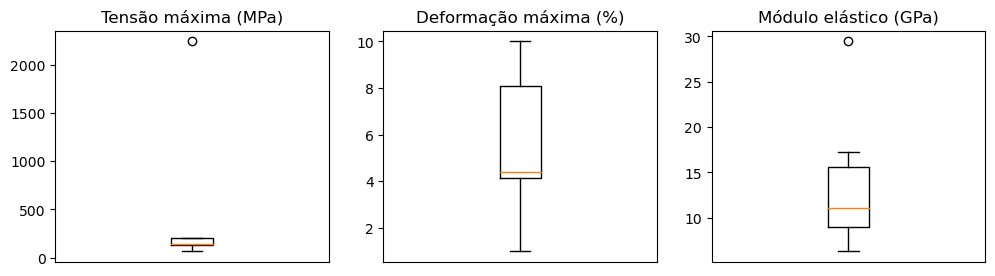

In [8]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros_sexta1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [9]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))
### ----------------------------------------------------------------------------

negativos = []
posivos = []

for me, cp in zip(resultados["Módulo elástico (GPa)"], resultados["CP"]):
    if me < 0:
        negativos.append(cp)
        #print(f"{cp} tem módulo = {me} e é menor que 0")
    else:
        posivos.append(cp)


Tensão máxima média (MPa): 146.19 ± 42.27
 
Deformação máxima média (%): 6.32 ± 2.46
 
Módulo elástico (GPa): 11.02 ± 3.71



# 7ª Filamentação 

In [10]:
############################### Importando os dados ##############################################

caminho_pasta = "7ª Filamentacao"

arquivos = os.listdir(caminho_pasta)

diametros_setima = [0.063, 0.051, 0.050, 0.04, 0.065, 0.066, 0.052, 0.05, 0.035]

diametros_setima1 = [i * 1000 for i in diametros_setima] # converter de mm para um

dados = list()

caminho_pasta1= "7ª Filamentacao/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))

In [11]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros_setima1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau


------------------------------------ Todos os CPs -------------------------------------------

      CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
cp14.txt                 63.0           100.160869               7.006950               8.358531
cp15.txt                 51.0           144.922661               7.432500              12.495616
cp16.txt                 50.0           153.247672               7.233300              11.106985
cp17.txt                 40.0           216.276528               5.624505              15.909556
cp18.txt                 65.0           227.676326              11.374300               0.810844
cp19.txt                 66.0           104.502509               6.264700               8.384280
cp20.txt                 52.0           141.688394               6.783100              10.311964
cp21.txt                 50.0           112.051191               2.383250              10.977845
cp23.txt                 35.0  

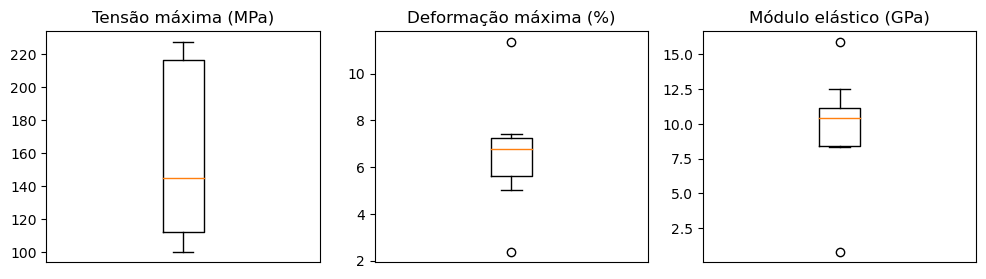

In [12]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros_setima1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [13]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))
### ----------------------------------------------------------------------------

negativos = []
posivos = []

for me, cp in zip(resultados["Módulo elástico (GPa)"], resultados["CP"]):
    if me < 0:
        negativos.append(cp)
        #print(f"{cp} tem módulo = {me} e é menor que 0")
    else:
        posivos.append(cp)


Tensão máxima média (MPa): 144.41 ± 40.10
 
Deformação máxima média (%): 6.62 ± 0.81
 
Módulo elástico (GPa): 10.17 ± 1.46



# 8ª Filamentação

In [14]:
############################### Importando os dados ##############################################

caminho_pasta = "8ª Filamentacao/Amostra 1"

arquivos = os.listdir(caminho_pasta)

diametros1 = [0.057, 0.059, 0.060, 0.053, 0.043, 0.057, 0.046, 0.051, 0.059, 0.050] # amostra 5

diametros1 = [i * 1000 for i in diametros1] # converter de mm para um

dados = list()

caminho_pasta1= "8ª Filamentacao/Amostra 1/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))


In [15]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau



------------------------------------ Todos os CPs -------------------------------------------

            CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
 8F_A1_CP1.txt                 57.0            55.156471                1.90755               4.596565
8F_A1_CP10.txt                 59.0            94.676937                3.60615               5.674472
 8F_A1_CP2.txt                 60.0            78.385967                1.42425               6.965214
 8F_A1_CP3.txt                 53.0           145.192414                6.39990              11.870521
 8F_A1_CP4.txt                 43.0           170.446078                3.62315              12.507828
 8F_A1_CP5.txt                 57.0            82.416886                2.23295               6.458732
 8F_A1_CP6.txt                 46.0           156.723393                5.14945              12.091458
 8F_A1_CP7.txt                 51.0           121.163355                7.74860 

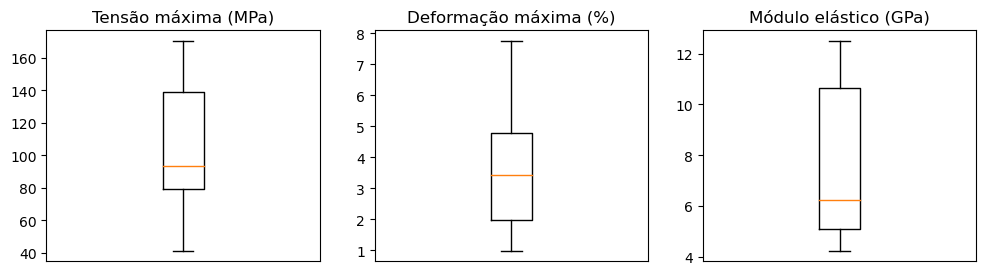

In [16]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [17]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))
### ----------------------------------------------------------------------------

negativos = []
posivos = []

for me, cp in zip(resultados["Módulo elástico (GPa)"], resultados["CP"]):
    if me < 0:
        negativos.append(cp)
        #print(f"{cp} tem módulo = {me} e é menor que 0")
    else:
        posivos.append(cp)


Tensão máxima média (MPa): 103.71 ± 41.08
 
Deformação máxima média (%): 3.63 ± 2.09
 
Módulo elástico (GPa): 7.53 ± 3.13



In [18]:
############################### Importando os dados ##############################################

caminho_pasta = "8ª Filamentacao/Amostra 2"

arquivos = os.listdir(caminho_pasta)

diametros1 = [0.056, 0.050, 0.057, 0.065, 0.059, 0.066, 0.065, 0.065, 0.060, 0.053, 0.052] # amostra 5

diametros1 = [i * 1000 for i in diametros1] # converter de mm para um

dados = list()

caminho_pasta1= "8ª Filamentacao/Amostra 2/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))


In [19]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau



------------------------------------ Todos os CPs -------------------------------------------

            CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
 8F_A2_CP1.txt                 56.0           118.884885               3.816050              -0.042503
8F_A2_CP10.txt                 50.0           202.687512               2.815450              15.639545
8F_A2_CP11.txt                 57.0           130.598833               5.825950               3.605147
8F_A2_CP12.txt                 65.0           116.031721               3.567350               6.971438
 8F_A2_CP2.txt                 59.0           113.610568               4.439300              10.307375
 8F_A2_CP3.txt                 66.0            96.465141               1.800700               7.514532
 8F_A2_CP5.txt                 65.0            97.994844               1.757200               8.341680
 8F_A2_CP6.txt                 65.0           105.794001               5.816400 

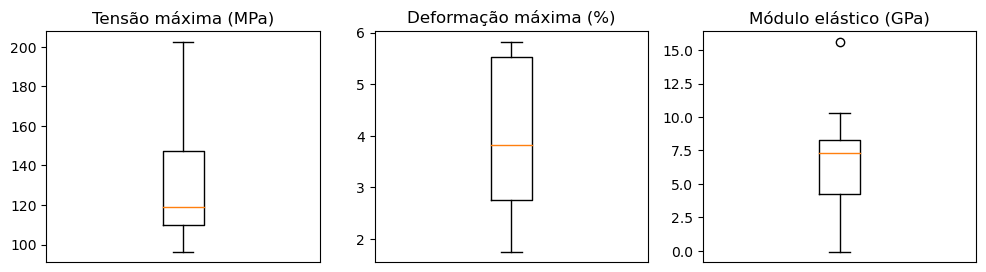

In [20]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [21]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))
### ----------------------------------------------------------------------------


Tensão máxima média (MPa): 124.29 ± 25.06
 
Deformação máxima média (%): 4.08 ± 1.53
 
Módulo elástico (GPa): 6.07 ± 2.90



In [22]:
############################### Importando os dados ##############################################

caminho_pasta = "8ª Filamentacao/Amostra 3"

arquivos = os.listdir(caminho_pasta)

diametros1 = [0.025, 0.018, 0.025] # amostra 5

diametros1 = [i * 1000 for i in diametros1] # converter de mm para um

dados = list()

caminho_pasta1= "8ª Filamentacao/Amostra 3/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))

In [23]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau



------------------------------------ Todos os CPs -------------------------------------------

           CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
8F_A3_CP1.txt                 25.0           135.124329               3.466000               1.609765
8F_A3_CP2.txt                 18.0           343.303107               2.674550               3.395442
8F_A3_CP4.txt                 25.0           158.195430               1.685341               5.977997

----------------------------- Após eliminação de outliers -----------------------------------

           CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
8F_A3_CP1.txt                 25.0           135.124329               3.466000               1.609765
8F_A3_CP2.txt                 18.0           343.303107               2.674550               3.395442
8F_A3_CP4.txt                 25.0           158.195430               1.685341               5

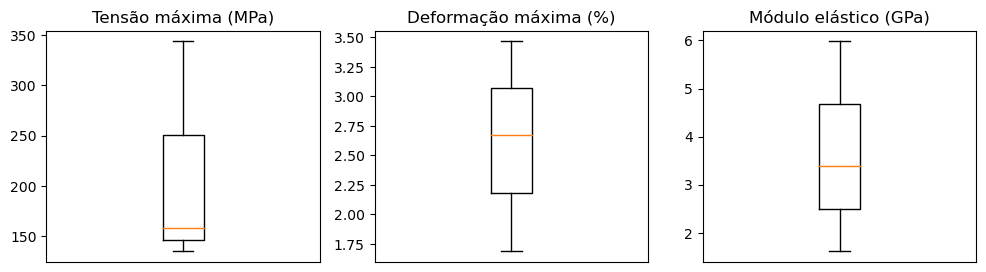

In [24]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [25]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))
### ----------------------------------------------------------------------------


Tensão máxima média (MPa): 212.21 ± 93.18
 
Deformação máxima média (%): 2.61 ± 0.73
 
Módulo elástico (GPa): 3.66 ± 1.79



In [69]:
############################### Importando os dados ##############################################

caminho_pasta = "8ª Filamentacao/Amostra 4"

arquivos = os.listdir(caminho_pasta)

diametros1 = [0.018, 0.026, 0.008, 0.011, 0.007, 0.008, 0.004, 0.012, 0.011, 0.011]

diametros1 = [i * 1000 for i in diametros1] # converter de mm para um

dados = list()

caminho_pasta1= "8ª Filamentacao/Amostra 4/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))

In [27]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau



------------------------------------ Todos os CPs -------------------------------------------

            CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
 8F_A4_CP1.txt                 18.0           457.749265                7.76850              15.789163
8F_A4_CP10.txt                 26.0           487.537736                7.78454               2.300216
8F_A4_CP11.txt                  8.0          4312.661282                3.33560             214.363386
8F_A4_CP12.txt                 11.0          1089.502660                0.89940              90.686806
8F_A4_CP13.txt                  7.0           126.110479               19.82575               5.641518
 8F_A4_CP2.txt                  8.0          4023.060958                3.38280             250.763732
 8F_A4_CP4.txt                  4.0          9783.811394                2.66700               1.751399
 8F_A4_CP5.txt                 12.0           901.214865                0.79160 

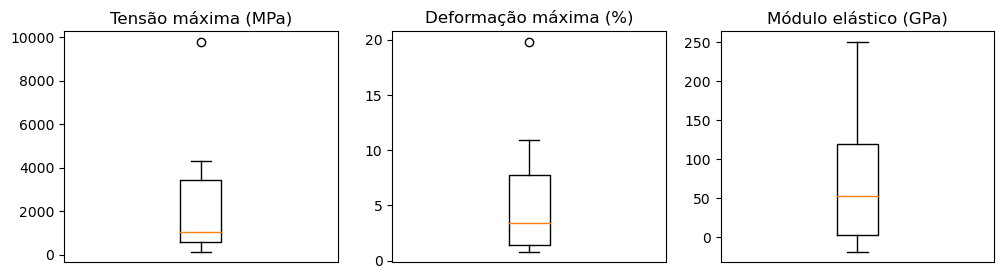

In [28]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [29]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))
### ----------------------------------------------------------------------------


Tensão máxima média (MPa): 1740.93 ± 1444.73
 
Deformação máxima média (%): 4.50 ± 3.61
 
Módulo elástico (GPa): 98.66 ± 91.65



In [64]:
############################### Importando os dados ##############################################

caminho_pasta = "8ª Filamentacao/Amostra 5"

arquivos = os.listdir(caminho_pasta)

diametros1 = [0.001, 0.004, 0.005, 0.007, 0.003]

diametros1 = [i * 1000 for i in diametros1] # converter de mm para um

dados = list()

caminho_pasta1= "8ª Filamentacao/Amostra 5/"

for i,df in enumerate(arquivos):
  dados.append(pd.read_csv(str(caminho_pasta1 + df), sep="\t"))

In [66]:
############################ Pré-tratamento #########################################################

# Excluindo valores muito pequenos, considerando o erro da célula de carga
for i,dado in enumerate(dados):
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    if dados[i].loc[j, ('Deformacao(mm)')] < 0.001 or dados[i].loc[j, ('Forca(N)')] < 0.001 and j > 0:
      dados[i] = dados[i].drop([j], axis = 0)
    # Resetando o index
  dados[i] = dados[i].reset_index(drop = True)

# Excluindo parte plana antes da curva
  
# Definindo um limite mínimo para a derivada que indica o início da subida
limite_subida = 0.002

for i, curva in enumerate(arquivos):

    derivada = np.diff(dados[i]['Forca(N)'])
  
    # Encontrar o primeiro índice onde a derivada é maior que o limite
    inicio_subida = np.argmax(derivada > limite_subida)
    
    # Filtra a curva para pegar apenas os valores a partir do início da subida
    curva_filtrada = dados[i]["Forca(N)"].iloc[inicio_subida + 1:]  # +1 para alinhar com o índice original

    dados[i]['Curva Filtrada'] = curva_filtrada

for i, curva in enumerate(arquivos):
  dados[i] = dados[i].dropna()
  dados[i] = dados[i].reset_index(drop = True)


# Calculando os valores de deformação e tensão
for i,dado in enumerate(dados):
  
  # Dividindo o valor de deformação pelo comprimento do corpo de prova
  for j,valor_deformacao in enumerate(dados[i]['Deformacao(mm)']):
    dados[i].loc[j, ('Deformacao(mm)')] = dados[i].loc[j, ('Deformacao(mm)')] / 20

  # Cálculo da tensão (Tensão = Força / pi.raio^2)
  for j,valor_forca in enumerate(dados[i]['Forca(N)']):
    dados[i].loc[j, ('Forca(N)')] = 4 * 10 ** -6 * dados[i].loc[j, ('Forca(N)')] / (math.pi * (diametros1[i] * 10 ** -6) ** 2)


# Normalizando os valores de tensão
for i,curva in enumerate(arquivos):
  degrau = dados[i]['Forca(N)'][1]
  for j in range(1, len(dados[i]['Forca(N)'])):
    dados[i]['Forca(N)'][j] = dados[i]['Forca(N)'][j] - degrau

# Deletando os dados pós ruptura
# Ruptura se caracteriza por diferença grande entre um dado e o dado anterior
# Passo necessário para não computar um valor incorreto de deformação máxima
ruptura = [0] * len(arquivos)
for i,curva in enumerate(arquivos):
  for j in range(1, len(dados[i]['Forca(N)'])):
    if abs(dados[i]['Forca(N)'][j] - dados[i]['Forca(N)'][j - 1]) > 35:
      ruptura[i] = j - 1
  if (ruptura[i] != len(dados[i]['Forca(N)'])) and (ruptura[i] != 0):
    for j in range(ruptura[i], len(dados[i]['Forca(N)'])):
      dados[i] = dados[i].drop([j])
    dados[i] = dados[i].reset_index()
    dados[i] = dados[i].drop(columns = 'index')

# Atualizando os valores de deformação
for i in range(len(arquivos)):
  degrau = dados[i]['Deformacao(mm)'][0]
  for j in range(len(dados[i]['Deformacao(mm)'])):
    dados[i]['Deformacao(mm)'][j] = dados[i]['Deformacao(mm)'][j] - degrau



------------------------------------ Todos os CPs -------------------------------------------

               CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
    8F_A5_CP1.txt                  1.0        105049.901878                1.00725           -2551.028824
   8F_A5_CP10.txt                  4.0         13904.014561                2.88450             679.448954
   8F_A5_CP12.txt                  5.0          8074.431919               10.77189             158.904263
    8F_A5_CP5.txt                  7.0          5506.864969                1.77420             299.825781
8F_A5_CP8_CP9.txt                  3.0         25176.034313                1.29946            2608.007499

----------------------------- Após eliminação de outliers -----------------------------------

               CP  Diâmetro médio (um)  Tensão máxima (MPa)  Deformação máxima (%)  Módulo elástico (GPa)
   8F_A5_CP10.txt                  4.0         13904.014561       

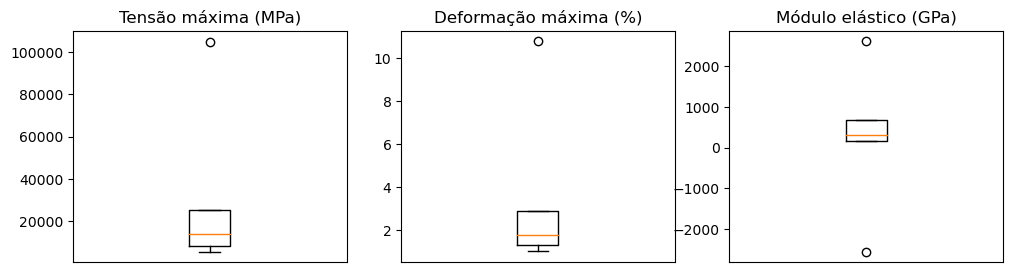

In [67]:
#################################### Calculando ###########################################

tensao_maxima, deformacao_maxima, modulo_elastico = ([0]*len(dados) for i in range(3))

# Cálculo da tensão máxima e da deformação máxima
for i, dado in enumerate(dados):
  tensao_maxima[i] = max(dados[i].loc[:, ('Forca(N)')])
  deformacao_maxima[i] = 100 * max(dados[i].loc[:, ('Deformacao(mm)')])

# Cálculo do módulo elástico
# Definição do valor de deformação mais proximo de 0,5%
def mais_proximo(lista_dados, K):
  return lista_dados[min(range(len(lista_dados)),
                         key = lambda i: abs(lista_dados[i] - K))]

# Obtenção da reta por interpolação linear entre o primeiro valor de
# deformação (0,0) e o valor mais próximo de 0,5%
for i, dado in enumerate(dados):
  numero_mais_proximo = mais_proximo(dados[i]['Deformacao(mm)'], 0.005)
  indice = dados[i]['Deformacao(mm)'][dados[i]['Deformacao(mm)'] == numero_mais_proximo].index[0]
  coeff = np.polyfit(dados[i]['Deformacao(mm)'][:indice],
                     dados[i]['Forca(N)'][:indice],
                     1)
  
  # Módulo elástico (GPa) é dado pela inclinação da reta:
  modulo_elastico[i] = coeff[0] / 1000

  resultados = pd.DataFrame({'CP': arquivos,
                           'Diâmetro médio (um)': diametros1,
                           'Tensão máxima (MPa)': tensao_maxima,
                           'Deformação máxima (%)': deformacao_maxima,
                           'Módulo elástico (GPa)': modulo_elastico}
                          )

colunas_resultados = list(resultados.columns)

print('\n------------------------------------ Todos os CPs ---------------'+
      '----------------------------\n')
print(resultados.to_string(index = False))

# Plotagem dos boxplots para todas as propriedades mecânicas
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,3))
ax1.boxplot(tensao_maxima)
ax1.set_title('Tensão máxima (MPa)')
ax1.set_xticks([])
ax2.boxplot(deformacao_maxima)
ax2.set_title('Deformação máxima (%)')
ax2.set_xticks([])
ax3.boxplot(modulo_elastico)
ax3.set_title('Módulo elástico (GPa)')
ax3.set_xticks([])

print('\n----------------------------- Após eliminação de outliers -------'+
      '----------------------------\n')

Q1, Q3, IQR, filtro = ([0, 0, 0] for i in range(4))

# Definindo primeiro e terceiro quartis (Q1 e Q3), amplitude (IQR) e filtrando
# os dados com base na análise dos quartis
for i in range(3):
  propriedade = colunas_resultados[i + 2]
  Q1[i] = resultados[propriedade].quantile(0.25)
  Q3[i] = resultados[propriedade].quantile(0.75)
  IQR[i] = Q3[i] - Q1[i]
  filtro[i] = (resultados[propriedade] >= 
               Q1[i] - 1.5 * IQR[i]) & (resultados[propriedade] <=
                                        Q3[i] + 1.5 *IQR[i])
  # Aplicação do filtro:
  resultados = resultados.loc[filtro[i]]

print(resultados.to_string(index = False))
print('\n')

In [68]:
### Computação resultados sem outliers

Deformacao, Forca = ([0]*len(arquivos) for i in range(2))

# Impressão dos resultados
print('\nTensão máxima média (MPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Tensão máxima (MPa)']),
                                                              np.std(resultados['Tensão máxima (MPa)'])),
      '\nDeformação máxima média (%): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Deformação máxima (%)']),
                                                                np.std(resultados['Deformação máxima (%)'])),
      '\nMódulo elástico (GPa): {:.2f} ± {:.2f}\n'.format(np.mean(resultados['Módulo elástico (GPa)']),
                                                          np.std(resultados['Módulo elástico (GPa)'])))
### ----------------------------------------------------------------------------


Tensão máxima média (MPa): 14862.30 ± 8058.44
 
Deformação máxima média (%): 1.99 ± 0.66
 
Módulo elástico (GPa): 1195.76 ± 1010.56

